#### Belgium Wind and Solar Energy in OSM

In [1]:
import pandas as pd
import numpy as np
import shapely
from OSMHandlers import PowerSourceHandler
from utils import *

import matplotlib.pyplot as plt
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from sklearn.cluster import DBSCAN

from OSMHandlers import RelationPowerHandler
from collections import Counter
from OSMHandlers import BuildingHandler

import osmium
import shapely.wkb as wkblib
from rtree import index
import json

from OSMHandlers import ImpactFactorsHandler
from shapely import wkt

import warnings
warnings.filterwarnings('ignore')

Data paths:

In [2]:
input_file = '../data/BE.pbf'

________

Use the customed osmium handler to extract generators and plants from OSM, and filter sources of interest:

In [3]:
handler = PowerSourceHandler()
handler.apply_file(input_file)

In [4]:
filter_sources = ['solar', 'wind']

df_power_sources = pd.DataFrame(handler.power_sources)
solar_wind_df = df_power_sources[df_power_sources.power_source.isin(filter_sources)]

In [5]:
solar_wind_df.id.nunique() == len(solar_wind_df)

True

In [6]:
# according to OSM Tag Wiki, "power=plant" may be a multipolygon/area or a relation, 
# while "power=generator" may be a node, a way or a multipolygon/area.

# here plants are also mapped as ways (but not nodes) --> mapping error
print('Are there plants wrongly mapped as ways?: {}'.format(solar_wind_df[solar_wind_df.power_tag=='plant'].id.str.startswith('w').any()))
print('Are there plants wrongly mapped as nodes?: {}'.format(solar_wind_df[solar_wind_df.power_tag=='plant'].id.str.startswith('n').any())) # no plants as node

Are there plants wrongly mapped as ways?: True
Are there plants wrongly mapped as nodes?: False


In [7]:
print('Out of {} sources, {} are wind and {} are solar sources.'.format(len(solar_wind_df), len(solar_wind_df[solar_wind_df.power_source=='wind']), len(solar_wind_df[solar_wind_df.power_source=='solar'])))

Out of 26203 sources, 1476 are wind and 24727 are solar sources.


___________

### OSM geometry types: redundancies and mapping mistakes

Example:

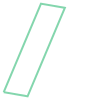

In [8]:
solar_wind_df[solar_wind_df.id=='w90868103'].geometry.item()

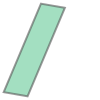

In [9]:
solar_wind_df[solar_wind_df.id=='a181736206'].geometry.item()

In [10]:
# the two geometries (when converted to same shapely type) are the same
lstr_indx = solar_wind_df[solar_wind_df.id == 'w90868103'].index.item()
area_indx = solar_wind_df[solar_wind_df.id == 'a181736206'].index.item()

lstr_as_multipoly = shapely.MultiPolygon([shapely.Polygon(solar_wind_df.loc[lstr_indx].geometry)]) 

lstr_as_multipoly.equals_exact(solar_wind_df.loc[area_indx].geometry, tolerance=0.0011)

True

In [11]:
# they contain the same sets of nodes
set(solar_wind_df.at[area_indx, 'nodesID_in_area']) == set(solar_wind_df.at[lstr_indx, 'nodesID_in_way'])

True

#### Fix redundancies: use set of nodes in way/area to check if the object is duplicated

In [12]:
# dataframe with only ways and areas
solar_wind_ways_and_areas = solar_wind_df[~solar_wind_df.id.str.startswith('n')].reset_index(drop=True)

# create a unique column with nodes set contained in each area and way (nodesID_in_area + nodesID_in_way as python set)
solar_wind_ways_and_areas['merged_nodes_in_obj'] = np.where(solar_wind_ways_and_areas['nodesID_in_area'].notnull(), solar_wind_ways_and_areas['nodesID_in_area'], solar_wind_ways_and_areas['nodesID_in_way'])
# column type as set
solar_wind_ways_and_areas['merged_nodes_in_obj'] = solar_wind_ways_and_areas.apply(lambda row: set(row['merged_nodes_in_obj']), axis=1)
# bool column: True if object is duplicated
solar_wind_ways_and_areas['duplicated_objs'] = solar_wind_ways_and_areas.merged_nodes_in_obj.duplicated(keep=False) # keep=False mark all duplicated as True


In [13]:
# get all duplicates that are ways --> put them in a list of ids to drop
ids_to_drop = solar_wind_ways_and_areas[(solar_wind_ways_and_areas.duplicated_objs==True)&(solar_wind_ways_and_areas.id.str.startswith('w'))].id.to_list()

In [14]:
# drop them from temporary dataframe and check again if there are duplicated among areas (two or more time the same multipolygon)
solar_wind_ways_and_areas = solar_wind_ways_and_areas[~(solar_wind_ways_and_areas.id.isin(ids_to_drop))].reset_index(drop=True)

# check again if there are duplicated 
if solar_wind_ways_and_areas.merged_nodes_in_obj.duplicated(keep=False).any():
    raise ValueError('Re-run duplicates check for duplicated areas!')

In [15]:
# drop duplicates in ids_to_drop from solar_wind_df
solar_wind_df = solar_wind_df[~(solar_wind_df.id.isin(ids_to_drop))].reset_index(drop=True)

In [16]:
print('Found {} objects that were mapped both as ways and areas: duplicated dropped, kept areas.'.format(len(ids_to_drop)))

Found 4929 objects that were mapped both as ways and areas: duplicated dropped, kept areas.


In [17]:
print(f'Current number of solar and wind source: {len(solar_wind_df)}')

Current number of solar and wind source: 21274


In [18]:
len(solar_wind_df[solar_wind_df.id.str.startswith('w')]) # no more ways :)

0

_____

#### Check OSM data types: are objects mapped using their correct geometry type?
According to OSM Tag Wiki, plants may be areas or relations, while generator can be nodes, ways or areas.

In [19]:
solar_wind_df[solar_wind_df.power_tag=='plant'].id.str.startswith('n').any() # no plants as node

False

In [20]:
solar_wind_df[solar_wind_df.power_tag=='plant'].id.str.startswith('w').any() # no plants as node

False

____

#### Check if duplicated nodes are present

In [21]:
solar_wind_nodes_only = solar_wind_df[solar_wind_df.id.str.startswith('n')]

In [22]:
solar_wind_nodes_only.geometry.nunique() == len(solar_wind_nodes_only) # DUPLICATED NODES GEOMETRIES

False

In [23]:
solar_wind_nodes_only['duplicated_bool'] = solar_wind_nodes_only.duplicated(subset=['geometry'], keep=False)

3 nodes are duplicated (they are all in the same building complex, and mapped by the same user):  
- [n10743225627](https://www.openstreetmap.org/node/10743225627) and [n10742227998](https://www.openstreetmap.org/node/10742227998)
- [n10742227997](https://www.openstreetmap.org/node/10742227997) and [n10743225626](https://www.openstreetmap.org/node/10743225626)
- [n10743225628](https://www.openstreetmap.org/node/10743225628) and [n10742227999](https://www.openstreetmap.org/node/10742227999)

In [24]:
solar_wind_nodes_only[solar_wind_nodes_only.duplicated_bool==True]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates,duplicated_bool
14111,n10742227997,50.995668,3.340993,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3409931 50.9956682),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14112,n10742227998,50.995628,3.340891,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3408912 50.9956277),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14113,n10742227999,50.995589,3.340791,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3407906 50.9955889),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14114,n10743225626,50.995668,3.340993,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3409931 50.9956682),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14115,n10743225627,50.995628,3.340891,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3408912 50.9956277),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14116,n10743225628,50.995589,3.340791,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.3407906 50.9955889),NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [25]:
solar_wind_nodes_only[solar_wind_nodes_only.id=='n10743225626'].geometry.item() == solar_wind_nodes_only[solar_wind_nodes_only.id=='n10742227997'].geometry.item()

True

In [26]:
geoms_dupl_cnt  = Counter(solar_wind_nodes_only.geometry)

print('Duplicated nodes: ')
[(k,geoms_dupl_cnt[k]) for k in geoms_dupl_cnt if geoms_dupl_cnt[k] > 1]

Duplicated nodes: 


[(<POINT (3.341 50.996)>, 2),
 (<POINT (3.341 50.996)>, 2),
 (<POINT (3.341 50.996)>, 2)]

In [27]:
# keep first geom and mark the second ones as duplicate of the same geom reappears
solar_wind_nodes_only['duplicated_keep_False'] = solar_wind_nodes_only.duplicated(subset=['geometry'], keep='first')

# check that after excluding duplicated geoms the len match
len(solar_wind_nodes_only[solar_wind_nodes_only.duplicated_keep_False == False]) == solar_wind_nodes_only.geometry.nunique()

True

In [28]:
# drop duplicated nodes
ids_dupl_nodes_to_drop = solar_wind_nodes_only[solar_wind_nodes_only.duplicated_keep_False == True].id.to_list()

ids_dupl_nodes_to_drop

['n10743225626', 'n10743225627', 'n10743225628']

In [29]:
# drop duplicated nodes geometries from main dataset
solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(ids_dupl_nodes_to_drop)].reset_index(drop=True)

______

Check for duplicated nodes, with a tollerance of 0.00001, to check if there are perhaps not exactly equal geometries but still representing same object mapped more than once.

In [30]:
# tol = 0.00001
# solar_wind_nodes_only = solar_wind_nodes_only[~solar_wind_nodes_only.id.isin(ids_dupl_nodes_to_drop)].reset_index(drop=True)
# duplicated_nodes_bool = check_equal_geometries(solar_wind_nodes_only, tolerance=tol)

# print('Is there any duplicated node (with {} tollerance): {}'.format(tol, duplicated_nodes_bool))


______

Re-check for duplicated (if lenghts do not match, then there are still duplicated geometries - either ways, areas, or nodes).

In [30]:
solar_wind_df.geometry.nunique() == len(solar_wind_df) # no duplicated geometries :)

True

_____

#### Check if Turbines or PV panels belong to any area using point-in-polygon search

In [31]:
# get areas only 
# areas may be intended as relations among nodes 
# --> check if nodes belong to areas and mark each node belonging to an area (most likely wind/solar farm)
solar_wind_areas = gpd.GeoDataFrame(solar_wind_df[solar_wind_df.id.str.startswith('a')].reset_index(drop=True), geometry='geometry')
solar_wind_nodes = gpd.GeoDataFrame(solar_wind_df[solar_wind_df.id.str.startswith('n')].reset_index(drop=True), geometry='geometry')

In [32]:
nodes_in_areas = point_in_polygon_with_spatial_index(source_gdf=solar_wind_nodes, intersecting_gdf=solar_wind_areas)
nodes_in_areas

,node_id,area_id
0,n33518330,a182007566
1,n1056722830,a182007566
2,n2650008942,a12127855
3,n6000767362,a12127855
4,n6000767367,a12127855
...,...,...
121,n6900050563,a1579957714
122,n7924828896,a2059274286
123,n9593533130,a2084268860
124,n10225391225,a2236060742


### **NOTE**: NEED TO CHECK THAT PT IS OF THE SAME POWER-SOURCE OF THE AREA

Example: https://www.openstreetmap.org/way/91003783  
In this example, some wind turbines are located inside a solar farm

In [33]:
# add nodes power source to nodes_in_areas
nodes_in_areas = pd.merge(nodes_in_areas, solar_wind_df[['id', 'power_source']], right_on='id', left_on='node_id', how='left')
nodes_in_areas = nodes_in_areas.rename(columns={'power_source': 'node_power_source'})
nodes_in_areas.drop(columns=['id'], inplace=True)

# add areas power source to nodes_in_areas
nodes_in_areas = pd.merge(nodes_in_areas, solar_wind_df[['id', 'power_source']], right_on='id', left_on='area_id', how='left')
nodes_in_areas = nodes_in_areas.rename(columns={'power_source': 'area_power_source'})
nodes_in_areas.drop(columns=['id'], inplace=True)

nodes_in_areas

,node_id,area_id,node_power_source,area_power_source
0,n33518330,a182007566,wind,solar
1,n1056722830,a182007566,wind,solar
2,n2650008942,a12127855,wind,wind
3,n6000767362,a12127855,wind,wind
4,n6000767367,a12127855,wind,wind
...,...,...,...,...
121,n6900050563,a1579957714,wind,wind
122,n7924828896,a2059274286,wind,wind
123,n9593533130,a2084268860,wind,wind
124,n10225391225,a2236060742,solar,solar


In [34]:
# TURBINES INSIDE A SOLAR AREA!!!! 
# TO REMOVE, AS THIS AREA MATCH IS NOT WHAT WE ARE LOOKING FOR
nodes_in_areas[nodes_in_areas.node_power_source != nodes_in_areas.area_power_source]

,node_id,area_id,node_power_source,area_power_source
0,n33518330,a182007566,wind,solar
1,n1056722830,a182007566,wind,solar


In [35]:
nodes_in_areas = nodes_in_areas[nodes_in_areas.node_power_source == nodes_in_areas.area_power_source].reset_index(drop=True)
nodes_in_areas

,node_id,area_id,node_power_source,area_power_source
0,n2650008942,a12127855,wind,wind
1,n6000767362,a12127855,wind,wind
2,n6000767367,a12127855,wind,wind
3,n6000767366,a12127855,wind,wind
4,n6000767372,a12127855,wind,wind
...,...,...,...,...
119,n6900050563,a1579957714,wind,wind
120,n7924828896,a2059274286,wind,wind
121,n9593533130,a2084268860,wind,wind
122,n10225391225,a2236060742,solar,solar


In [36]:
nodes_in_areas.isna().any()

node_id              False
area_id              False
node_power_source    False
area_power_source    False
dtype: bool

In [37]:
if nodes_in_areas.node_id.duplicated().any():
    raise ValueError('One or more nodes (turbines or PV panel) belong to multiple areas! Check it!')

_____________

#### Address the following questions:
1. is there any area not inside nodes_in_areas (namely areas that do not have any power-node belonging to them recorded into the solar_wind_df dataframe)?  

    --> yes! In the case of **wind sources**, this happens when a small circular area is built around a single wind turbine; this is a **mapping error, as the turbine should be mapped as a node and not an area!**  
    
    For solar sources, this may happen for solar farm, as panels inside solar farms are usually (but not always) not singularly mapped, or for single solar generators ([cfr. wiki](https://wiki.openstreetmap.org/wiki/Tag:generator:source%3Dsolar#Mapping_Photovoltaic_Generators)).

In [38]:
# is there any area not in nodes_in_area?? 
# namely, areas that do not have single PV panel or turbines mapped

area_without_nodes = []
for area in solar_wind_areas.id.to_list():
    if area not in nodes_in_areas.area_id.to_list():
        area_without_nodes.append(area)

print('Areas without nodes: {}'.format(len(area_without_nodes)))

Areas without nodes: 4942


In [39]:
# AREAS THAT DO NOT HAVE NODES MAPPED INSIDE
solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))].power_source.unique()

array(['solar', 'wind'], dtype=object)

In [40]:
tot_areas_without_nodes = len(solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))])
pv_areas_without_nodes = len( solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))&(solar_wind_areas.power_source == 'solar')] )
wind_areas_without_nodes = len( solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))&(solar_wind_areas.power_source == 'wind')] )

print('Of {} areas without mapped nodes inside, \n - {} of them is/are photovoltaic \n - {} is/are wind turbine(s).'.format(tot_areas_without_nodes, pv_areas_without_nodes, wind_areas_without_nodes))

Of 4942 areas without mapped nodes inside, 
 - 4896 of them is/are photovoltaic 
 - 46 is/are wind turbine(s).


WIND AREAS WITHOUT NODES

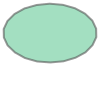

In [41]:
# get geometries wind sources areas without nodes mapped inside
wind_areas_no_nodes = solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))&(solar_wind_areas.power_source == 'wind')].reset_index(drop=True)

# set crs
wind_areas_no_nodes = gpd.GeoDataFrame(wind_areas_no_nodes, geometry='geometry', crs='EPSG:4326')

wind_areas_no_nodes.at[5, 'geometry']

Wind areas without nodes mapped inside are all small circles around a single wind turbine.

Example: https://www.openstreetmap.org/way/1178732930

They should have been mapped as NODES!!! Get the center of the geometry and replace areas with that nodes. Then check again for duplicates to make sure that some turbines were not already mapped as both areas and nodes.

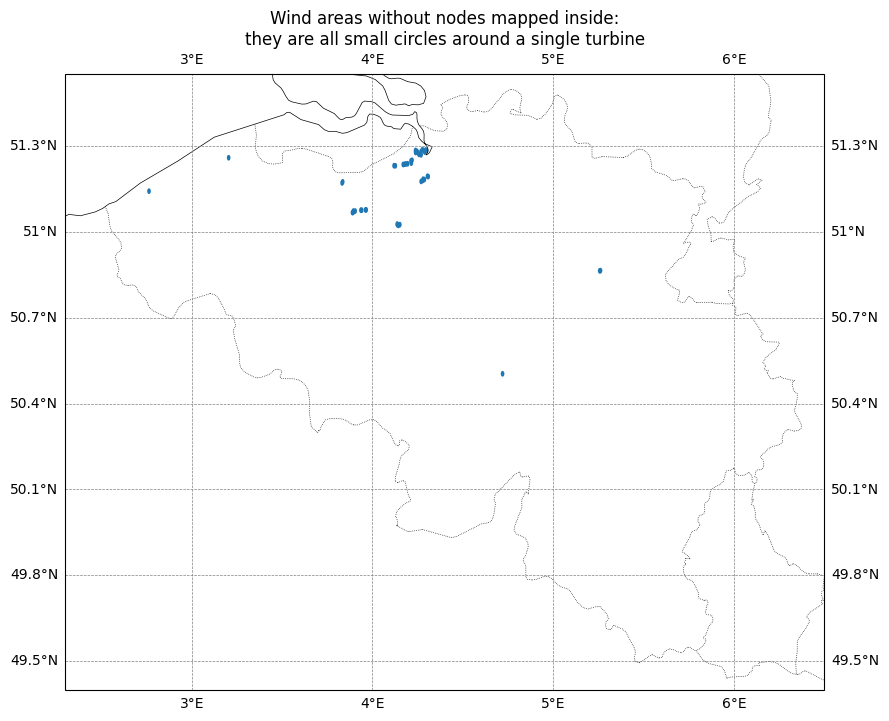

In [42]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 51.55])  # long-lat boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

wind_areas_no_nodes.buffer(0.01).plot(ax=ax, linewidth=50) # NEED TO APPLY BUFFER TO BE VISIBLE ON MAP

ax.set_title('Wind areas without nodes mapped inside:\nthey are all small circles around a single turbine')

plt.show()

In [43]:
# create copy of "fake-areas" dataframe
wind_areas_to_nodes = wind_areas_no_nodes.copy()
# replace areas geometries with their centroid
wind_areas_to_nodes['geometry'] = wind_areas_to_nodes.centroid
# change id so that it is no longer an area ("a") but a node ("n") id
wind_areas_to_nodes['id'] = 'n'+wind_areas_to_nodes.id.str[1:]
wind_areas_to_nodes['nodesID_in_area'], wind_areas_to_nodes['area_coordinates'] = None, None
wind_areas_to_nodes.head()

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates
0,n993052328,NaN,NaN,generator,None,wind,horizontal_axis,POINT (2.76382 51.14124),NaN,NaN,NaN,NaN,NaN,None,None
1,n2100474892,NaN,NaN,generator,wind_turbine,wind,horizontal_axis,POINT (5.2575 50.86333),NaN,NaN,NaN,NaN,NaN,None,None
2,n2100474894,NaN,NaN,generator,wind_turbine,wind,horizontal_axis,POINT (5.26236 50.8639),NaN,NaN,NaN,NaN,NaN,None,None
3,n2172724416,NaN,NaN,generator,wind_turbine,wind,None,POINT (3.8949 51.07188),NaN,NaN,NaN,NaN,NaN,None,None
4,n2172724512,NaN,NaN,generator,wind_turbine,wind,wind_turbine,POINT (3.90454 51.0718),NaN,NaN,NaN,NaN,NaN,None,None


In [44]:
# drop rows with "fake-areas" and add rows where those areas are converted to nodes
fake_areas_to_drop = wind_areas_no_nodes.id.to_list()
solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(fake_areas_to_drop)]
solar_wind_df = pd.concat([solar_wind_df, wind_areas_to_nodes]).reset_index(drop=True)

In [45]:
# check that we did not introduced nodes duplicates
solar_wind_nodes_only = solar_wind_df[solar_wind_df.id.str.startswith('n')]
if solar_wind_nodes_only.geometry.nunique() == len(solar_wind_nodes_only):
    print('No exact nodes duplicates!')

    # tol = 0.00001
    # print('Check duplicated nodes with {} tollerance...'.format(tol))

    # solar_wind_nodes_only = solar_wind_nodes_only[~solar_wind_nodes_only.id.isin(ids_dupl_nodes_to_drop)].reset_index(drop=True)
    # duplicated_nodes_bool = check_equal_geometries(solar_wind_nodes_only, tolerance=tol)

    # print('Is there any duplicated node (with {} tollerance): {}'.format(tol, duplicated_nodes_bool))

    # if duplicated_nodes_bool:
    #     raise ValueError('Introduced duplicated nodes!!! Remove them!')
else:
    print('There are duplicated POINT geometries!')

No exact nodes duplicates!


SOLAR AREAS WITHOUT NODES

In [46]:
solar_no_nodes = solar_wind_areas[(solar_wind_areas.id.isin(area_without_nodes))&(solar_wind_areas.power_source == 'solar')] 

In [47]:
solar_no_nodes.power_method.value_counts()

power_method
photovoltaic    4759
thermal           23
solar              1
fission            1
Name: count, dtype: int64

2. are there nodes not belonging to any area? Why?  

    --> in the case of solar energy, single nodes not included in areas may be private solar installations on rooftops (to discard)  
    --> in the case of wind energy, it is likely the single turbines belong to a wind farm not mapped (apply clustering)

NODES NOT IN AREAS
 - for **wind_turbine**, most likely there is an UNMAPPED farm --> run clustering
 - for **photovoltaic**, most likely they are single pannels on rooftops --> less of interest, focus on solar farm, thus may be discarded

In [48]:
# number of nodes not in area per source
solar_wind_df[(solar_wind_df.id.str.startswith('n'))&(~solar_wind_df.id.isin(nodes_in_areas.node_id.to_list()))].groupby('power_source').aggregate({'id':'count'})

,id
power_source,
solar,14946
wind,1297


In [49]:
# total nodes per source
solar_wind_df[solar_wind_df.id.str.startswith('n')].groupby('power_source').aggregate({'id':'count'}) 

,id
power_source,
solar,14948
wind,1419


In [50]:
# percentage of nodes not in area over total number of nodes per source
solar_wind_df[(solar_wind_df.id.str.startswith('n'))&(~solar_wind_df.id.isin(nodes_in_areas.node_id.to_list()))].groupby('power_source').aggregate({'id':'count'}) * 100 / solar_wind_df[solar_wind_df.id.str.startswith('n')].groupby('power_source').aggregate({'id':'count'}) 

,id
power_source,
solar,99.986620
wind,91.402396


Deal with nodes not in areas

In [51]:
# deal with nodes not in any areas
nodes_not_in_areas = solar_wind_df[(solar_wind_df.id.str.startswith('n'))&(~solar_wind_df.id.isin(nodes_in_areas.node_id.to_list()))] 

# SOLAR
nodes_pv_not_in_areas = nodes_not_in_areas[nodes_not_in_areas.power_source == 'solar']

In [52]:
nodes_pv_not_in_areas.power_method.unique(), nodes_pv_not_in_areas.power_type.unique()

(array(['photovoltaic', None, 'thermal'], dtype=object),
 array(['solar_photovoltaic_panel', None, 'solar_thermal_collector'],
       dtype=object))

In [53]:
nodes_pv_not_in_areas.relation_id.unique() # never in relations

array([nan])

In [54]:
nodes_pv_not_in_areas = gpd.GeoDataFrame(nodes_pv_not_in_areas, geometry='geometry', crs='EPSG:4326')

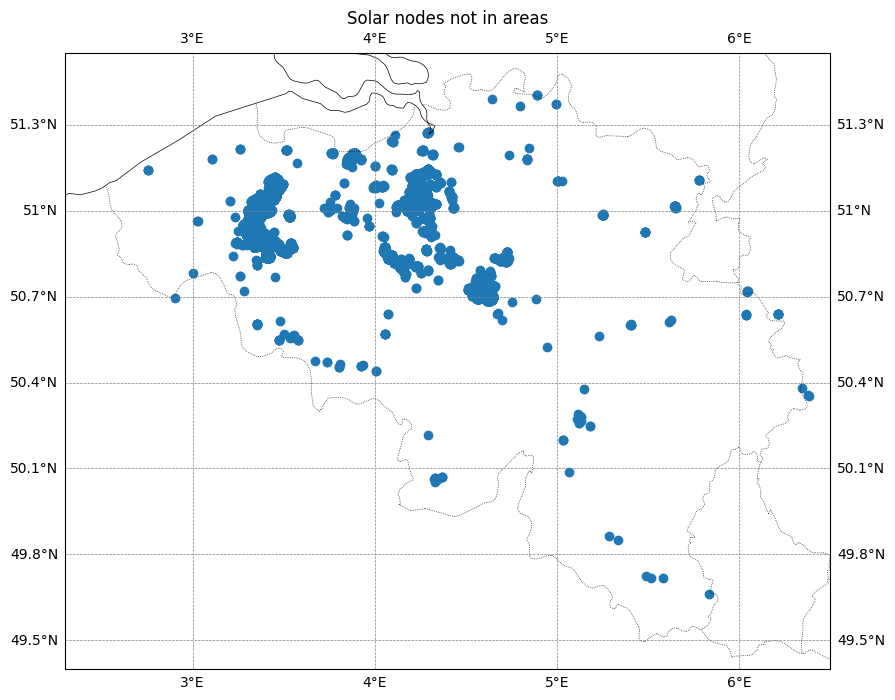

In [55]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 51.55])  # long-lat boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

nodes_pv_not_in_areas.plot(ax=ax) 

ax.set_title('Solar nodes not in areas')

plt.show()

In [56]:
nodes_pv_not_in_areas.power_tag.unique() # pv panels not in areas or relations are all generators

array(['generator'], dtype=object)

In [57]:
len(nodes_pv_not_in_areas.id.to_list())

14946

According to these observations, and considering the wiki of [Tag:generator:source=solar](https://wiki.openstreetmap.org/wiki/Tag:generator:source%3Dsolar), generators with solar source, are **OSM nodes** only when representing a rooftop solar panel or a solar thermal collector placed on private roofs.  
Manual explorations on **openstreetmap.org** of some of these nodes seems to confirm such statement as well.  
Therefore all solar generators mapped as nodes can be discarded as single private installations, and not solar farms.

In [58]:
# drop single installation of solar generators on rooftops
solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(nodes_pv_not_in_areas.id.to_list())]

Are there still solar infrastructure mapped as nodes?  
If yes, it means they belong to an area or relation thus **what are solar nodes in areas instead?**

In [59]:
# SOLAR IN AREAS
solar_in_area = nodes_in_areas[nodes_in_areas.node_power_source == 'solar']
solar_in_area

,node_id,area_id,node_power_source,area_power_source
122,n10225391225,a2236060742,solar,solar
123,n10992443584,a2367452476,solar,solar


In [60]:
nodes_solar = solar_wind_df[(solar_wind_df.power_source=='solar')&(solar_wind_df.id.str.startswith('n'))]
nodes_solar

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates
4029,n10225391225,50.483648,3.656000,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (3.6559998 50.4836482),NaN,NaN,NaN,NaN,NaN,NaN,NaN
14292,n10992443584,50.462611,5.643758,generator,photovoltaic,solar,solar_photovoltaic_panel,POINT (5.6437576 50.462611),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Both tagged "location=roof" on openstreetmap.org:
- https://www.openstreetmap.org/node/10225391225
- https://www.openstreetmap.org/node/10992443584  

thus, to discard, but check the area they belong to

In [61]:
solar_nodes_in_area = nodes_in_areas[nodes_in_areas.node_id.isin(nodes_solar.id.to_list())]
solar_wind_df[solar_wind_df.id.isin(solar_nodes_in_area.area_id)]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates
19233,a2236060742,NaN,NaN,generator,photovoltaic,solar,solar_photovoltaic_panel,"MULTIPOLYGON (((3.6556994 50.4836052, 3.655703...",NaN,NaN,NaN,NaN,NaN,"[10225391222, 10225391223, 10225391224, 102253...","[(50.4836052, 3.6556994), (50.4835908, 3.65570..."
19740,a2367452476,NaN,NaN,generator,photovoltaic,solar,solar_photovoltaic_panel,"MULTIPOLYGON (((5.643755 50.4626432, 5.6437576...",NaN,NaN,NaN,NaN,NaN,"[10992443581, 10992443584, 10992443583, 109924...","[(50.4626432, 5.643755), (50.462611, 5.6437576..."


Unusual mapping, with a generator as node inside another as area. However, these installations are to be considered single panels on rooftops, therefore to discard.

In [62]:
# discard
nodes_in_areas = nodes_in_areas[~nodes_in_areas.node_id.isin(nodes_solar.id.to_list())].reset_index(drop=True)
solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(nodes_solar.id.to_list())].reset_index(drop=True)

_________

WIND NOT IN AREAS OR RELATIONS

In [63]:
# WIND
nodes_wind_not_in_areas = nodes_not_in_areas[nodes_not_in_areas.power_source == 'wind']

In [64]:
# consider only turbines not in areas that are also not in relations
nodes_wind_not_in_areas = nodes_wind_not_in_areas[nodes_wind_not_in_areas.relation_id.isnull()].reset_index(drop=True)

nodes_wind_not_in_areas = gpd.GeoDataFrame(nodes_wind_not_in_areas, geometry='geometry', crs='EPSG:4326')

print('{} wind turbines are not in areas or relations.'.format(len(nodes_wind_not_in_areas)))

1265 wind turbines are not in areas or relations.


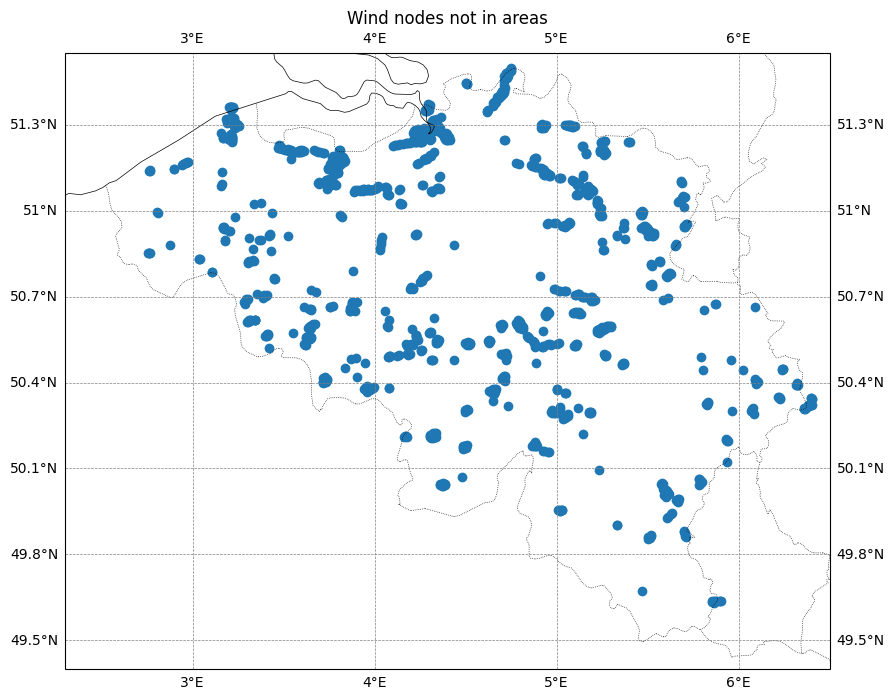

In [65]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 51.55])  # long-lat boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

nodes_wind_not_in_areas.plot(ax=ax) 

ax.set_title('Wind nodes not in areas')

plt.show()

It is unlikely that there are so many standalone turbines; most likely, they belong to unmapped farms or to existing areas or relations to which they need to be assigned.

Apply clustering to identify wind farms: ***DBSCAN***  
NOTE: include turbines already belonging to farms via OSM areas or relations, and then compare clustering results with OSM data.  
The clustering should confirm OSM data, identify unmapped farms, and augment mapped wind farms with turbines that failed to be included.

In [66]:
wind_nodes_to_cluster = gpd.GeoDataFrame(solar_wind_df[solar_wind_df.power_source=='wind'], geometry='geometry', crs='EPSG:4326')
wind_nodes_to_cluster = wind_nodes_to_cluster[wind_nodes_to_cluster.id.str.startswith('n')].reset_index(drop=True)

In [67]:
# TO METRIC SYSTEM --> CLUSTER BASED ON DISTANCE IN METERS
epsg_meter = 'EPSG:3035'
wind_nodes_to_cluster_metric = wind_nodes_to_cluster.to_crs(epsg_meter)
wind_nodes_to_cluster_metric['lon'], wind_nodes_to_cluster_metric['lat'] = wind_nodes_to_cluster_metric.geometry.x, wind_nodes_to_cluster_metric.geometry.y


# DBSCAN parameters:
# eps: maximum distance between two samples for one to be considered as in the neighborhood of the other
avg_rotor_diameter = 130 # meters 
eps = 5*avg_rotor_diameter # 5 times the rotor diameter (reasonable maximum distance on average for onshore wind turbines belonging to the same farm)
# min_samples: number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself. 
# If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.
min_samples = 2 # minimum 2 turbines per cluster

# apply DBSCAN clustering
clusterer = DBSCAN(eps = eps, 
                   min_samples = min_samples,
                   metric = 'euclidean') 
clusterer.fit(wind_nodes_to_cluster_metric[['lon', 'lat']])

DBSCAN(eps=650, min_samples=2)

In [68]:
# add labels computed on metric dataframe to LON/LAT dataframe 
wind_nodes_to_cluster['cluster'] = clusterer.labels_
wind_nodes_to_cluster['cluster'].nunique() # number of clusters

252

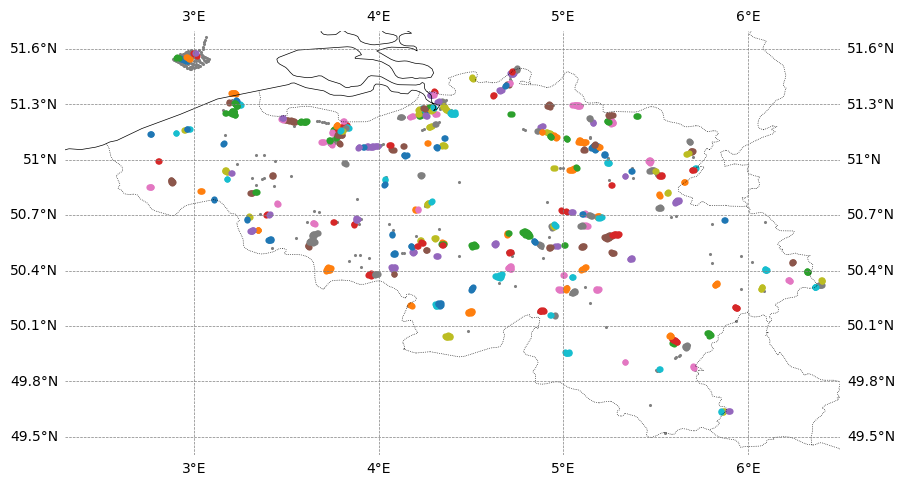

In [69]:
### plot
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

# basemap
ax.set_extent([2.3, 6.5, 49.4, 51.7])
    
# external boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)

# internal boundaries
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)

# grid & coords labels
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# handle points that are not part of any cluster (noise)
noise = wind_nodes_to_cluster[wind_nodes_to_cluster['cluster'] == -1]
ax.scatter(noise.geometry.x, noise.geometry.y, c='grey', s=5, linewidth=0)

# plot all points that are not noise, with different colors based on their cluster label
unique_labels = wind_nodes_to_cluster['cluster'].unique()
for label in unique_labels:
    if label == -1:
        continue  
    cluster_points = wind_nodes_to_cluster[wind_nodes_to_cluster['cluster'] == label]
    ax.scatter(cluster_points.geometry.x, cluster_points.geometry.y, 
                   label=f'Cluster {label}', s=20, linewidth=0)  

ax.set_axis_off()
plt.show()

In [70]:
print('Found {} turbines belongs to farms, while {} are standalone wind turbines.'.format(len(wind_nodes_to_cluster[wind_nodes_to_cluster.cluster != -1]), len(wind_nodes_to_cluster[wind_nodes_to_cluster.cluster == -1])))

Found 1166 turbines belongs to farms, while 253 are standalone wind turbines.


In [71]:
# isolate noise (standalone turbines)
standalone_turbines = wind_nodes_to_cluster[wind_nodes_to_cluster.cluster == -1].id.to_list()

#### Check correspondance clustering results and OSM areas/relations.

Consider **STANDALONE TURBINES**:

Relations:   
there is [1 clustering standalone turbine in a OSM relations](https://www.openstreetmap.org/relation/4126309#map=14/49.5173/5.5684): it actually belongs to a farm, but in France. This turbines is on the other side of the border with France: discard it.

Areas:  
there are 99 standalone turbines (cluster -1) in OSM areas: 98 of them are all **OFFSHORE** turbines, and it makes sense that they are clustered as -1, as the maximum distance for offshore turbines belonging to the same farm is much higher.  
The single standalone turbine on land has some mapping issues: it is unclear whether there is one turbine that has been linked to an area, or there are two turbines, one of which has been mapped as an area by mistake (should have been a node) ([link to map](https://www.openstreetmap.org/way/1042134430)).

Overall, the standalone turbines resulting by clustering make sense, and unveiled new mapping issues.  
All turbines assigned to cluster -1 can be discared as they are to be considered standalone turbines.

Correspondance with OSM Relations:

In [72]:
# standalone turbines in OSM RELATION --> this is beyond the border with France
wind_nodes_to_cluster[(wind_nodes_to_cluster.cluster == -1)&(wind_nodes_to_cluster.relation_id.isnull()==False)]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates,cluster
412,n3142619392,49.519778,5.548028,generator,wind_turbine,wind,horizontal_axis,POINT (5.54803 49.51978),4126309.0,site,wind_farm,NaN,NaN,NaN,NaN,-1


Correspondance with OSM Areas:

In [73]:
# standalone turbines in OSM AREAS

# add area_id (OSM areas of belonging) as column to wind_nodes_to_cluster
wind_nodes_to_cluster['area_id'] = None
for node in range(len(nodes_in_areas)):
    node_id = nodes_in_areas.at[node, 'node_id']
    area_id = nodes_in_areas.at[node, 'area_id']
    wind_nodes_to_cluster.loc[wind_nodes_to_cluster['id'] == node_id, 'area_id'] = area_id

In [74]:
wind_standalone_in_areas = wind_nodes_to_cluster[(wind_nodes_to_cluster.cluster == -1)&(wind_nodes_to_cluster.area_id.isnull()==False)]

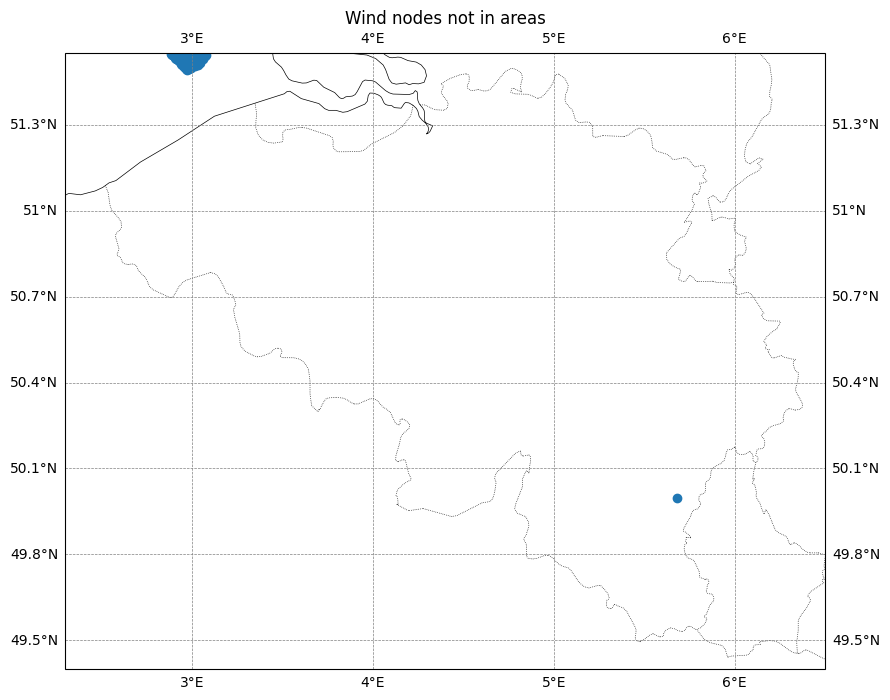

In [75]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 51.55])  # long-lat boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

wind_standalone_in_areas.plot(ax=ax) 

ax.set_title('Wind nodes not in areas')

plt.show()

In [76]:
# single node on land that seems to mismatch --> mapping error: https://www.openstreetmap.org/way/1042134430
wind_standalone_in_areas[wind_standalone_in_areas.lat < 50]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,nodesID_in_way,way_coordinates,nodesID_in_area,area_coordinates,cluster,area_id
1261,n9593533130,49.997772,5.68195,generator,wind_turbine,wind,None,POINT (5.68195 49.99777),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,a2084268860


Discard -1 cluster:

In [77]:
# drop standalone wind turbines
nodes_in_areas = nodes_in_areas[~nodes_in_areas.area_id.isin(wind_standalone_in_areas.area_id.unique())]
wind_nodes_to_cluster = wind_nodes_to_cluster[~wind_nodes_to_cluster.id.isin(standalone_turbines)].reset_index(drop=True)
solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(np.concatenate([wind_standalone_in_areas.area_id.unique(), standalone_turbines]))].reset_index(drop=True)

Consider **turbines assigned to clusters**: how well does clustering match OSM relation/area data?  
--> wind turbines in the same OSM areas assigned to different clusters are all **OFFSHORE**: this once again makes sense as offshore wind turbines have a greater maximum distance between one another.

In [78]:
# rows with same area_id should also have save cluster --> check this! If nunique greater than 1, than for that area_id multiple clusters are defined
cluster_per_area = wind_nodes_to_cluster.groupby('area_id')['cluster'].nunique().reset_index()
areas_with_multiple_clusters = cluster_per_area[cluster_per_area.cluster != 1].area_id.to_list()
areas_with_multiple_clusters

['a12127855']

In [79]:
multiple_cluster_df = wind_nodes_to_cluster[wind_nodes_to_cluster.area_id.isin(areas_with_multiple_clusters)]

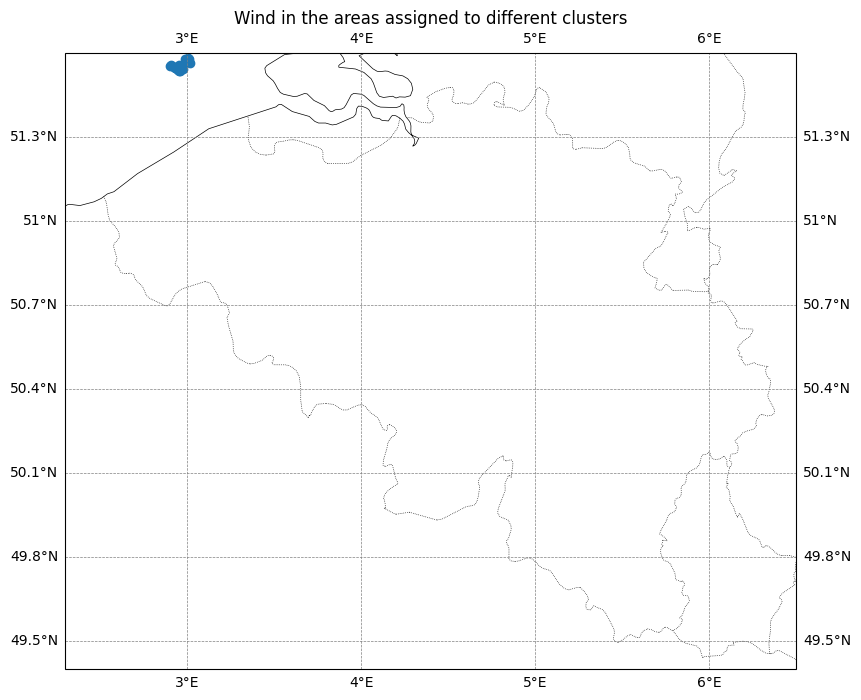

In [80]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 51.6])  # long-lat boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

multiple_cluster_df.plot(ax=ax) 

ax.set_title('Wind in the areas assigned to different clusters')

plt.show()

In [81]:
areas_with_multiple_clusters

['a12127855']

In [82]:
# areas_with_multiple_clusters are all offshore, thus not of interest for this analysis: can be discarded
nodes_in_areas = nodes_in_areas[~nodes_in_areas.area_id.isin(areas_with_multiple_clusters)]
wind_nodes_to_cluster = wind_nodes_to_cluster[~wind_nodes_to_cluster.id.isin(multiple_cluster_df.id.to_list())].reset_index(drop=True)

solar_wind_df = solar_wind_df[~solar_wind_df.id.isin(np.concatenate([multiple_cluster_df.id.to_list(), areas_with_multiple_clusters]))].reset_index(drop=True) 

Relations:

In [83]:
# rows with same relation_id should also have save cluster (cluster count should be 1 --> if greater, there are turbines of same OSM relation belonging to different clusters)
cluster_per_relation = wind_nodes_to_cluster.groupby('relation_id')['cluster'].nunique().reset_index()
cluster_per_relation # cluster_per_relation[cluster_per_relation.cluster != 1].relation_id.to_list()

,relation_id,cluster
0,9214804.0,1
1,10143677.0,1
2,12524235.0,1
3,12524236.0,1


#### Clustering results

In [84]:
# clustering results
clustered_wind_farms = wind_nodes_to_cluster[['id', 'cluster']]
clustered_wind_farms

,id,cluster
0,n33518330,0
1,n258894561,1
2,n258894597,1
3,n258895042,1
4,n293029421,2
...,...,...
1139,n2363447976,48
1140,n2455660238,250
1141,n2456106378,250
1142,n2456114704,250


In [85]:
clustered_wind_farms.cluster.value_counts().mean() # avg number of turbines per cluster

4.650406504065041

_______

#### SOLAR PLANTS or GENERATORS
#### Other solar that are not solar farms: discard single and private generators, and retain only solar plants 

In [86]:
solar_wind_gdf = gpd.GeoDataFrame(solar_wind_df, geometry='geometry', crs='EPSG:4326')
solar_gdf = solar_wind_gdf[solar_wind_gdf.power_source == 'solar']

Filtering out installations on rooftops: unfeasable as it requires gathering data for all buildings in the country.

In [ ]:
'''# collects geometries of buildings 
buildings_handler = BuildingHandler()
buildings_handler.apply_file(input_file)
buildings_df = pd.DataFrame(buildings_handler.buildings)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')'''

"# collects geometries of buildings \nbuildings_handler = BuildingHandler()\nbuildings_handler.apply_file(input_file)\nbuildings_df = pd.DataFrame(buildings_handler.buildings)\nbuildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')"

A solar farm can be mapped as a single area with no element inside, or as an area with other areas (the panels) mapped within (cfr. [wiki](https://wiki.openstreetmap.org/wiki/Tag:generator:source%3Dsolar#Mapping_Photovoltaic_Generators)).  

Moreovers, the solar farms themselves should be mapped as **plants**, while the panels inside (and single installations from private parties) should be mapped as **generators**.   

The first thing to do is check whether this is respected. Consider **solar generators only**: if among this data there are areas containing **AT LEAST TWO** other solar areas, we are probably dealing with solar plants (farms) mistakenly mapped as generators. (Note: only one area within could still identify a private installation)   
Therefore, we should retain these data (if any), as well as solar plants data, and filter out all other generators.

Note that this approach is somehow conservative: we try to minimize the error in filtering out useful data, but there is still the chance that some solar plants will be discarded if poorly mapped. However, this also means maximizing the chance of having only correct data in our final dataset, which is truly important for meaningful and reliable future analyses.

In [87]:
solar_gdf_generators = solar_gdf[solar_gdf.power_tag == 'generator'].reset_index(drop=True)

In [88]:
# find areas in areas
solar_gen_containining_gen = point_in_polygon_with_spatial_index(source_gdf=solar_gdf_generators, intersecting_gdf=solar_gdf_generators, 
                                                                    source_id_col='id', intersecting_id_col='id',
                                                                    pt_in_poly_function = 'contains')
# exclude containement of itself 
solar_gen_containining_gen = solar_gen_containining_gen[solar_gen_containining_gen.gdf1_geom_id != solar_gen_containining_gen.gdf2_area_id].reset_index(drop=True)

In [89]:
# minimum number of panels to be contained for the containing area to be considered a farm
min_panels = 2

# each area in column gdf2_area_id should appear at least min_panels time 
n_panels_per_area = solar_gen_containining_gen.groupby('gdf2_area_id').size()

solar_gen_containining_gen = solar_gen_containining_gen[solar_gen_containining_gen['gdf2_area_id'].isin(n_panels_per_area[n_panels_per_area >= min_panels].index)]

In [90]:
solar_gen_containining_gen.rename(columns={'gdf1_geom_id':'single_panel_inside_plant', 'gdf2_area_id':'farm_area'})

,single_panel_inside_plant,farm_area
1,a1554009660,a933356026
2,a1554009664,a933356026
3,a1554009658,a933356026
4,a1554009662,a933356026
5,a1568852996,a933356026
...,...,...
116,a1782861844,a1782718008
117,a1782861846,a1782718008
118,a1782861848,a1782718008
119,a1782861850,a1782718008


In [91]:
# generators that are actually solar farms
identified_farms = solar_gen_containining_gen.gdf2_area_id.unique()
identified_farms

array(['a933356026', 'a957375710', 'a1371454910', 'a1782718008'],
      dtype=object)

In [92]:
len(identified_farms)

4

In [93]:
# PLOT IDENTIFIED SOLAR FARMS WRONGLY MAPPED AS GENERATORS
m = folium.Map(location=[50.5, 4], zoom_start=8)

# to geojson
solar_json = solar_gdf_generators[solar_gdf_generators.id.isin(identified_farms)].to_json()

folium.GeoJson(solar_json, color='red',
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.LayerControl().add_to(m)

m

KEEP SOLAR FARMS ONLY

In [94]:
# either plants or identified plants (from mapping error as generators)
solar_gdf = solar_gdf[(solar_gdf.power_tag == 'plant')|(solar_gdf.id.isin(identified_farms))].reset_index(drop=True)

**NOTE**: it seems less likely that a generator is mapped as a plant, but this may happen. At the current stage, we did not address the possible errors in mapping plants (e.g., single panel or generators mapped as plant). We may use the same criteria used above (i.e., it is an actual solar plant if it contains multiple panels), however single panels inside solar farms are often not mapped, therefore using this criteria can cause a significant data loss.

______

### Save cleaned datasets for solar and wind sources

#### SOLAR

In [95]:
# SOLAR SOURCES
print('Geometry types:', set(solar_gdf.id.str[:1].to_list()))

# save
solar_gdf.to_csv('output_data/BE/BE_solar_df.csv')

Geometry types: {'a'}


#### WIND

In [96]:
# WIND SOURCES
wind_pts_areas_df = solar_wind_df[solar_wind_df.power_source == 'wind'].reset_index(drop=True)

print('Geometry types:', set(wind_pts_areas_df.id.str[:1].to_list()))

Geometry types: {'n', 'a'}


1. ensure that all offshore turbines are removed and that no turbines outside the country borders (as found when applying DBSCAN) is left

In [97]:
# GET PHYSICAL BORDERS DATA FROM [NATURAL EARTH], TO FILTER ONLY INSTALLATIONS INSIDE LAND BORDERS (NOT OFFSHORE)
countries_pysical_borders = gpd.read_file('../data/ne_10m_admin_0_countries.zip')

# Belgium geometry
be = countries_pysical_borders[countries_pysical_borders.ADMIN=='Belgium'].geometry.item()

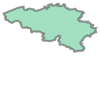

In [98]:
# be = be.buffer(0.01) # add buffer to not filter out geometries on borders
be

In [99]:
crs = 'EPSG:4326'  # WGS84
wind_pts_areas_df = gpd.GeoDataFrame(wind_pts_areas_df, geometry='geometry', crs=crs)

# mask to identify geometries contained within the multipolygon (physical borders)
mask_onshore = wind_pts_areas_df.geometry.within(be)
onshore_solar_wind_df = wind_pts_areas_df[mask_onshore]

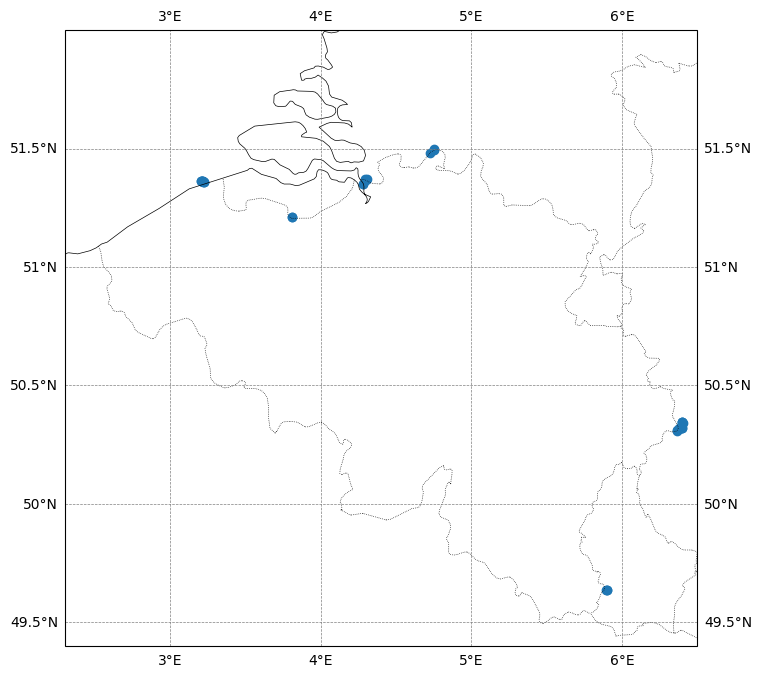

In [100]:
### plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 52])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

wind_pts_areas_df[~mask_onshore].plot(ax=ax)

plt.show()

In [101]:
# OFFSHORE WIND TURBINES
m = folium.Map(location=[50.5, 4], zoom_start=7)

# to geojson
offshore_json = wind_pts_areas_df[~mask_onshore].to_json()

folium.GeoJson(offshore_json, color='red',
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.LayerControl().add_to(m)

m

In [102]:
# INSPECT MAP TO SEE IF CATCHED ALL OFFSHORE TURBINES (IN RED) 
# --> ELSE ANJUST BE BUFFER
# NOTE: SOME FILTERED OUT TURBINES NEAR THE BORDER SEEMS TO BE ON THE OTHER SIDE
# OF THE BORDER OF BELGIUM

m = folium.Map(location=[50.5, 4], zoom_start=7)

# to geojson
offshore_df = wind_pts_areas_df[~mask_onshore]
wind_off_json = offshore_df.to_json()

wind_on_json = wind_pts_areas_df[mask_onshore].to_json()


folium.GeoJson(wind_off_json, name='Offshore Wind Farms', color='red', 
               marker=folium.Circle(radius=4, fill_color='red', fill_opacity=0.4, color='red', weight=3),
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.GeoJson(wind_on_json, name='Onshore Wind Farms', color='green', 
               marker=folium.Circle(radius=4, fill_color='green', fill_opacity=0.4, color='green', weight=3),
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.LayerControl().add_to(m)

m


Remove turbines outside country borders, and their clusters/farms.

In [103]:
# filter out offshore turbines/turbines outside borders
wind_pts_areas_onshore_df = wind_pts_areas_df[mask_onshore].reset_index(drop=True)

# remove other turbines in the same farm
id_farms_outside = clustered_wind_farms[clustered_wind_farms.id.isin(offshore_df.id.unique())].cluster.unique()
nodes_in_farms_outside = clustered_wind_farms[clustered_wind_farms.cluster.isin(id_farms_outside)].id.unique()

wind_pts_areas_onshore_df = wind_pts_areas_onshore_df[~wind_pts_areas_onshore_df.id.isin(nodes_in_farms_outside)].reset_index(drop=True)
clustered_wind_farms = clustered_wind_farms[~clustered_wind_farms.cluster.isin(id_farms_outside)].reset_index(drop=True)

2. detach areas and add area_id and cluster_id relations to dataset

In [104]:
# check
solar_ids = solar_wind_df[solar_wind_df.power_source=='solar'].id.unique() # no solar
offshore_ids = wind_pts_areas_df[~mask_onshore & (wind_pts_areas_df.id.str.startswith('a'))].id.to_list() # offshore farms
filter_out_not_onshore_turbines_sources = np.concatenate([solar_ids, offshore_ids])

nodes_in_wind_areas = nodes_in_areas[~nodes_in_areas.area_id.isin(filter_out_not_onshore_turbines_sources)].reset_index(drop=True)

if nodes_in_wind_areas.area_id.nunique() != wind_pts_areas_onshore_df[wind_pts_areas_onshore_df.id.str.startswith('a')].id.nunique():
    raise ValueError('Inconsistencies between number of areas in wind dataset and areas with nodes inside (wind farms) available.')

In [105]:
# wind areas (farms) data
wind_areas_df = wind_pts_areas_onshore_df[wind_pts_areas_onshore_df.id.str.startswith('a')].reset_index(drop=True)
wind_areas_df.to_csv('output_data/BE/BE_wind_areas_df.csv')


# wind turbines data
wind_df = wind_pts_areas_onshore_df[wind_pts_areas_onshore_df.id.str.startswith('n')].reset_index(drop=True)
# drop empty columns
wind_df = wind_df.drop(columns=['nodesID_in_area', 'nodesID_in_way', 'way_coordinates', 'area_coordinates'])

In [106]:
# add area_id as column to wind turbines data (farm which they belong to)
wind_df['area_id'] = None
for node in range(len(nodes_in_wind_areas)):
    node_id = nodes_in_wind_areas.at[node, 'node_id']
    area_id = nodes_in_wind_areas.at[node, 'area_id']
    wind_df.loc[wind_df['id'] == node_id, 'area_id'] = area_id

# do the same for clustering results
wind_df['cluster_id'] = None
for node in range(len(clustered_wind_farms)):
    node_id = clustered_wind_farms.at[node, 'id']
    cluster_id = clustered_wind_farms.at[node, 'cluster']
    wind_df.loc[wind_df['id'] == node_id, 'cluster_id'] = cluster_id

In [107]:
if len(wind_df[(wind_df.relation_id.isnull())&(wind_df.area_id.isnull())&(wind_df.cluster_id.isnull())]) != 0:
    raise ValueError('All wind turbines should belong to a farm (after filtering out standalone turbines), either via OSM relation, OSM area, or DBSCAN clustering.')

In [108]:
# PLOT ALL ONSHORE WIND SOURCES
m = folium.Map(location=[50.5, 4], zoom_start=7)

# to geojson
wind_df['cluster_id'] = wind_df['cluster_id'].astype(float) # to be json serializable
wind_turbines_json = gpd.GeoDataFrame(wind_df, geometry='geometry', crs='EPSG:4326').to_json() # nodes df to json
wind_farms_json = gpd.GeoDataFrame(wind_areas_df, geometry='geometry', crs='EPSG:4326').to_json() # areas df to json

folium.GeoJson(wind_turbines_json, name='Wind Turbines', color='green', 
               marker=folium.Circle(radius=4, fill_color='green', fill_opacity=0.4, color='green', weight=3),
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.GeoJson(wind_farms_json, name='Wind Farms Areas', color='green', 
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.LayerControl().add_to(m)

m

In [109]:
# save
wind_df.to_csv('output_data/BE/BE_wind_df.csv')

In [110]:
print('Wind turbines are connected with one another via:')
for col in ['relation_info', 'area_id', 'cluster_id']:
    print('{}: {} times'.format(col, len(wind_df[wind_df[col].isnull()==False])))

Wind turbines are connected with one another via:
relation_info: 31 times
area_id: 1 times
cluster_id: 1101 times


#### Final checks

Areas:
- [a2059274286](https://www.openstreetmap.org/#map=19/51.25299/4.40816) --> there is squared-area around a single turbine/node, but multiple other turbines are around (and where indeed clustered together): this turbine was added to the cluster

In [111]:
wind_df[wind_df['area_id'].isnull()==False]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,area_id,cluster_id
756,n7924828896,51.252995,4.408158,generator,wind_turbine,wind,horizontal_axis,POINT (4.40816 51.25299),NaN,NaN,NaN,a2059274286,139.0


In [112]:
ids = wind_df[wind_df['area_id'].isnull()==False].cluster_id.to_list()
wind_df[wind_df['cluster_id'].isin(ids)]

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,area_id,cluster_id
531,n4895806946,51.258014,4.392362,generator,wind_turbine,wind,horizontal_axis,POINT (4.39236 51.25801),NaN,NaN,NaN,None,139.0
532,n4895806947,51.254451,4.391082,generator,wind_turbine,wind,horizontal_axis,POINT (4.39108 51.25445),NaN,NaN,NaN,None,139.0
533,n4895806948,51.255483,4.383819,generator,wind_turbine,wind,horizontal_axis,POINT (4.38382 51.25548),NaN,NaN,NaN,None,139.0
534,n4895806949,51.249935,4.399787,generator,wind_turbine,wind,horizontal_axis,POINT (4.39979 51.24994),NaN,NaN,NaN,None,139.0
535,n4895806950,51.247568,4.392494,generator,wind_turbine,wind,horizontal_axis,POINT (4.39249 51.24757),NaN,NaN,NaN,None,139.0
536,n4895806951,51.245876,4.397987,generator,wind_turbine,wind,horizontal_axis,POINT (4.39799 51.24588),NaN,NaN,NaN,None,139.0
537,n4895806952,51.246390,4.405160,generator,wind_turbine,wind,horizontal_axis,POINT (4.40516 51.24639),NaN,NaN,NaN,None,139.0
538,n4927628932,51.254261,4.398556,generator,wind_turbine,wind,horizontal_axis,POINT (4.39856 51.25426),NaN,NaN,NaN,None,139.0
643,n5961023598,51.249967,4.389280,generator,wind_turbine,wind,horizontal_axis,POINT (4.38928 51.24997),NaN,NaN,NaN,None,139.0
755,n7924828895,51.250391,4.411379,generator,wind_turbine,wind,horizontal_axis,POINT (4.41138 51.25039),NaN,NaN,NaN,None,139.0


All these turbines have been clustered together but only one of them is mapped to a OSM area. This may allow us to take information from that area and extend them to all turbines in the cluster, and therefore enrich our knowledge about them all.

Relations:

In [114]:
wind_df[wind_df['relation_id'].isnull()==False].sort_values(by='cluster_id')

,id,lat,lon,power_tag,power_method,power_source,power_type,geometry,relation_id,relation_type,relation_info,area_id,cluster_id
30,n676199507,51.097178,5.080569,generator,wind_turbine,wind,horizontal_axis,POINT (5.08057 51.09718),12524236.0,site,wind_farm,None,11.0
31,n676199554,51.100789,5.083884,generator,wind_turbine,wind,horizontal_axis,POINT (5.08388 51.10079),12524236.0,site,wind_farm,None,11.0
32,n676199557,51.099111,5.090258,generator,wind_turbine,wind,horizontal_axis,POINT (5.09026 51.09911),12524236.0,site,wind_farm,None,11.0
33,n676199584,51.094774,5.097370,generator,wind_turbine,wind,horizontal_axis,POINT (5.09737 51.09477),12524236.0,site,wind_farm,None,11.0
34,n676199777,51.097920,5.095621,generator,wind_turbine,wind,horizontal_axis,POINT (5.09562 51.09792),12524236.0,site,wind_farm,None,11.0
638,n5769846583,51.096635,5.088270,generator,wind_turbine,wind,horizontal_axis,POINT (5.08827 51.09663),12524236.0,site,wind_farm,None,11.0
336,n2973457730,50.420029,4.087661,generator,wind_turbine,wind,horizontal_axis,POINT (4.08766 50.42003),12524235.0,site,wind_farm,None,14.0
136,n1482495595,50.403512,4.077916,generator,wind_turbine,wind,horizontal_axis,POINT (4.07792 50.40351),12524235.0,site,wind_farm,None,14.0
135,n1482495581,50.406610,4.084118,generator,wind_turbine,wind,horizontal_axis,POINT (4.08412 50.40661),12524235.0,site,wind_farm,None,14.0
89,n1255471220,50.416260,4.073593,generator,wind_turbine,wind,horizontal_axis,POINT (4.07359 50.41626),12524235.0,site,wind_farm,None,14.0
